# training_+ttbarModel.ipynb

This is code (in progress) for building and training the neural network.

## Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
from IPython.display import clear_output
# import keras_one_cycle_clr as ktool
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

import sys
sys.path.append("/home/jchishol/TRecNet")
import normalize
import shape_timesteps
import analysis

## Loading Files

In [13]:
# Data type we want to use
data_type = 'e+mjets_ttbar_addon_train'

# Dataset to train and test on
dataset = h5py.File('/data/jchishol/ML_Data/variables_ttbar_parton_'+data_type+'.h5','r')

# Numpy array of [max,mean] for each variable
X_maxmean = np.load('X_maxmean_parton_'+data_type+'.npy')
Y_maxmean = np.load('Y_maxmean_parton_'+data_type+'.npy')

## Useful Variables

In [14]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m','ttbar_pt','ttbar_eta','ttbar_phi','ttbar_m']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes

print(crop0)

9348801


## Scale the Data

In [1]:
# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

ModuleNotFoundError: No module named 'normalize'

## Split Data Into Training, Validation, and Testing

In [5]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
#split1 = int(np.floor(0.70*crop0))
#split2 = int(np.floor(0.85*crop0))
split = int(np.floor(0.82*crop0))  # Taking ~82% for training and ~18% for validation amounts to ~70% of total being training and ~15% of total being validation

# Split into training, validation, and testing data for Y
#trainY, valY, testY = Y_total[0:split1,:], Y_total[split1:split2,:], Y_total[split2:,:]
#print("Training:",trainY.size/Y_total.size)
#print("Validation:",valY.size/Y_total.size)
#print("Testing:",testY.size/Y_total.size)

trainY, valY = Y_total[0:split,:], Y_total[split:,:]

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into training, validation, and testing data for jets and other
#trainX_jets, valX_jets, testX_jets = totalX_jets[0:split1,:,:], totalX_jets[split1:split2,:,:], totalX_jets[split2:,:,:]
#trainX_other, valX_other, testX_other = totalX_other[0:split1,:], totalX_other[split1:split2,:], totalX_other[split2:,:]

trainX_jets, valX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, valX_other = totalX_other[0:split,:], totalX_other[split:,:]

## Histograms of Scaled Input X and Y Variables

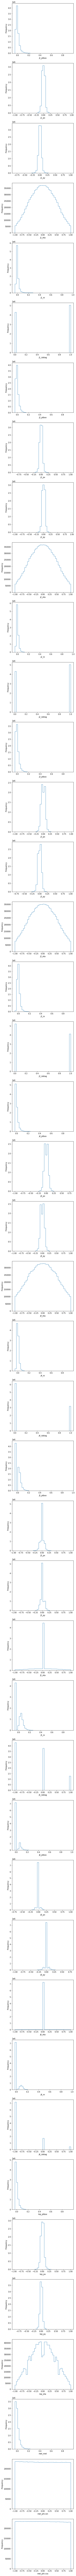

In [7]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

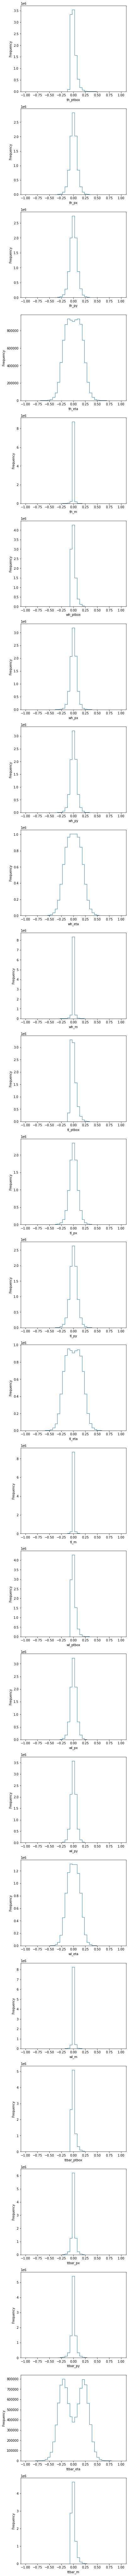

In [8]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

## Build the Model

In [9]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(256, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(10)(ldense2)   # 10 leptonic variable outputs
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(10+5)(hdense2)  # 10 hadronic variable outputs + 5 ttbar variable outputs
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    # Define loss function (do we even end up using this??)
    #def loss_fc(true, pred):
    #    return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

# Define loss function (again?)
#def loss_fc(true, pred):
#        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# Load or build model
#model = keras.models.load_model('new_model.keras', custom_objects={'loss_fc':loss_fc})
model = build_model()
model.summary()
keras.utils.plot_model(model,to_file='Model_Custom+ttbar.png',show_shapes=True,show_dtype=True,show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 43)           0           ['input_2[0][0]',                
                                                                  'flatten[0][0]']            

2022-05-30 15:12:55.466749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-05-30 15:12:55.466795: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-30 15:12:55.467308: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

## Fit the Model 

In [10]:
# From: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

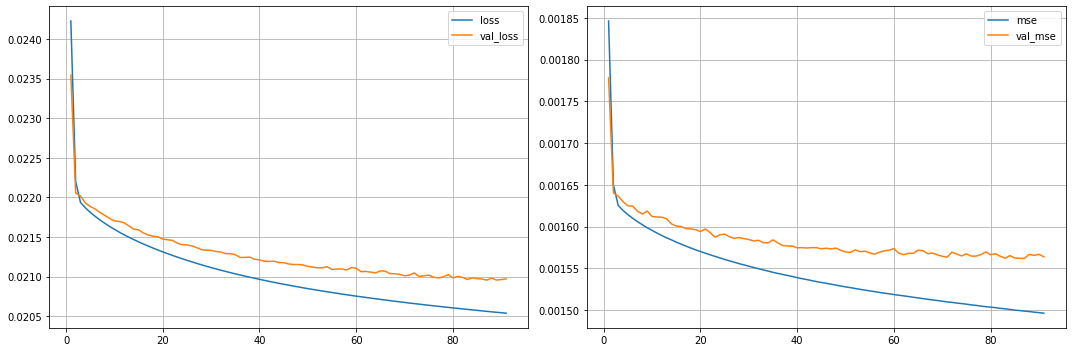

7667/7667 [==============================] - 127s 17ms/step - loss: 0.0205 - mse: 0.0015 - val_loss: 0.0210 - val_mse: 0.0016


In [11]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  # patience=4 means stop training after 4 epochs with no improvement
clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}

# Set number of epochs (runs through?)
Epochs= 256

# del X_total
# del Y_total
# def loss(true, pred):
#     return K.mean(K.square(true-pred)*(1+K.square(true)))


# Fit the model (i.e. TRAIN the model)
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY), shuffle=True, callbacks=[early_stop,PlotLearning()],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)

## Save the Model

In [12]:
model.save('Model_Custom+ttbar.keras')


In [13]:
np.save('trainHistory_Model_Custom+ttbar.npy',history.history)
#history=np.load('trainHistory_Model_Custom+ttbar.npy',allow_pickle='TRUE').item()

## Plot Training Stats 

In [ ]:
#plt.xlabel('Training Iterations')
#plt.ylabel('Learning Rate')
#plt.title("CLR - 'triangular' Policy")
#plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'MAE loss')

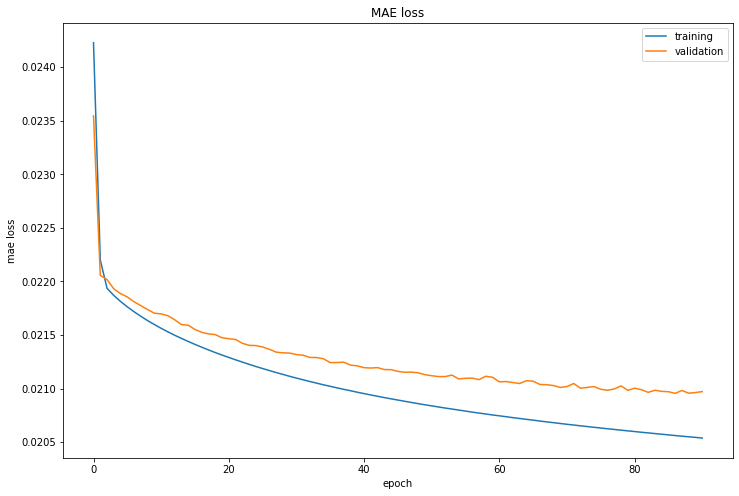

In [14]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mae loss') 
plt.legend()
plt.title('MAE loss')



# Testing and Plots

This part of the code tests the machine learning and data.

## Make Predictions with Test Data

In [6]:
model = keras.models.load_model('Model_Custom+ttbar.keras')

# Predict using un-scaled variables
predictions_unscaled = model.predict([valX_jets, valX_other])
true_unscaled = valY 

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

2022-05-31 09:55:47.183514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-05-31 09:55:47.183551: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-31 09:55:47.183952: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

## Training Scale Plots (Tao's Code)

In [7]:
Analysis = analysis.Analysis
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0015638406709220936
 
th_ptbox MSE, MAE :  0.0006299688 0.0169550935
th_px MSE, MAE :  0.0012179865 0.0206772815
th_py MSE, MAE :  0.0012968526 0.0214717876
th_eta MSE, MAE :  0.0055542240 0.0415134119
th_m MSE, MAE :  0.0005939691 0.0087228919
wh_ptbox MSE, MAE :  0.0006798118 0.0164068479
wh_px MSE, MAE :  0.0012493020 0.0207427553
wh_py MSE, MAE :  0.0012327638 0.0206552023
wh_eta MSE, MAE :  0.0067940850 0.0463021938
wh_m MSE, MAE :  0.0008002263 0.0123290226
tl_ptbox MSE, MAE :  0.0005176252 0.0162676371
tl_px MSE, MAE :  0.0008272614 0.0191571934
tl_py MSE, MAE :  0.0006509212 0.0169888494
tl_eta MSE, MAE :  0.0035911736 0.0394175602
tl_m MSE, MAE :  0.0006047659 0.0087794902
wl_ptbox MSE, MAE :  0.0002844452 0.0124285059
wl_px MSE, MAE :  0.0002979129 0.0128010594
wl_py MSE, MAE :  0.0002396538 0.0114952024
wl_eta MSE, MAE :  0.0022850921 0.0340332157
wl_m MSE, MAE :  0.0009340022 0.0133371706
ttbar_ptbox MSE, MAE :  0.0003463455 0.0123140243
ttbar_px MSE, MAE :  0.

In [8]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 689.1665601121703
 
th_pt MSE, MAE :  1848.3655973503 29.0425414320
th_eta MSE, MAE :  0.4663029101 0.3803739766
th_phi MSE, MAE :  0.6892920013 0.4535033265
th_m MSE, MAE :  35.3483631441 2.1279588945
wh_pt MSE, MAE :  1365.7848270444 23.2553001002
wh_eta MSE, MAE :  0.5400519677 0.4128134672
wh_phi MSE, MAE :  0.6574962624 0.4546449146
wh_m MSE, MAE :  36.2789604439 2.6251229061
tl_pt MSE, MAE :  1265.2078839295 25.4330068594
tl_eta MSE, MAE :  0.2982219409 0.3592041410
tl_phi MSE, MAE :  0.4098986537 0.3352340749
tl_m MSE, MAE :  35.9905165599 2.1417545928
wl_pt MSE, MAE :  626.4061861873 18.4436835265
wl_eta MSE, MAE :  0.2916628250 0.3844958633
wl_phi MSE, MAE :  0.1875132987 0.2446972473
wl_m MSE, MAE :  37.2245074034 2.6625896839
ttbar_pt MSE, MAE :  1532.3295195380 25.9012843374
ttbar_eta MSE, MAE :  0.8529906254 0.6351342513
ttbar_phi MSE, MAE :  1.2465308413 0.7647331305
ttbar_m MSE, MAE :  6987.0517395331 52.7871478958


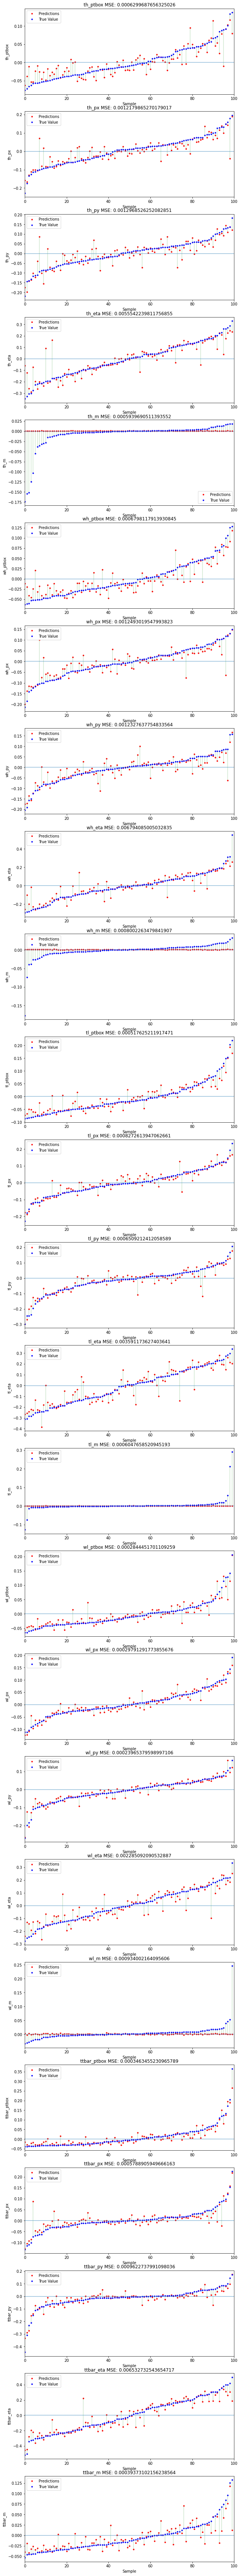

In [9]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)  # I think this is plotting the first 100 events? As like a sample

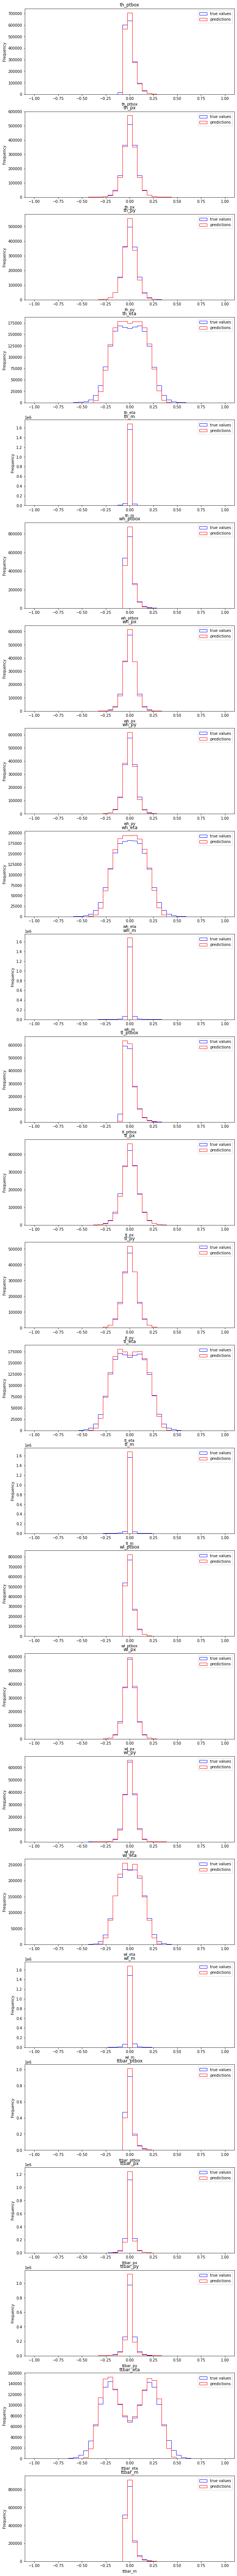

In [10]:
# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

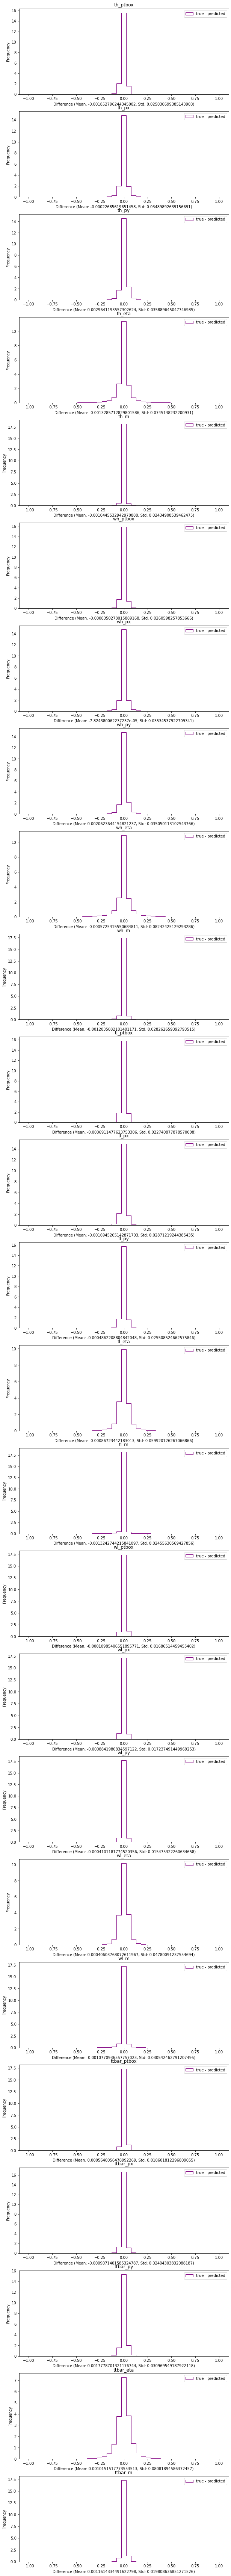

In [11]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

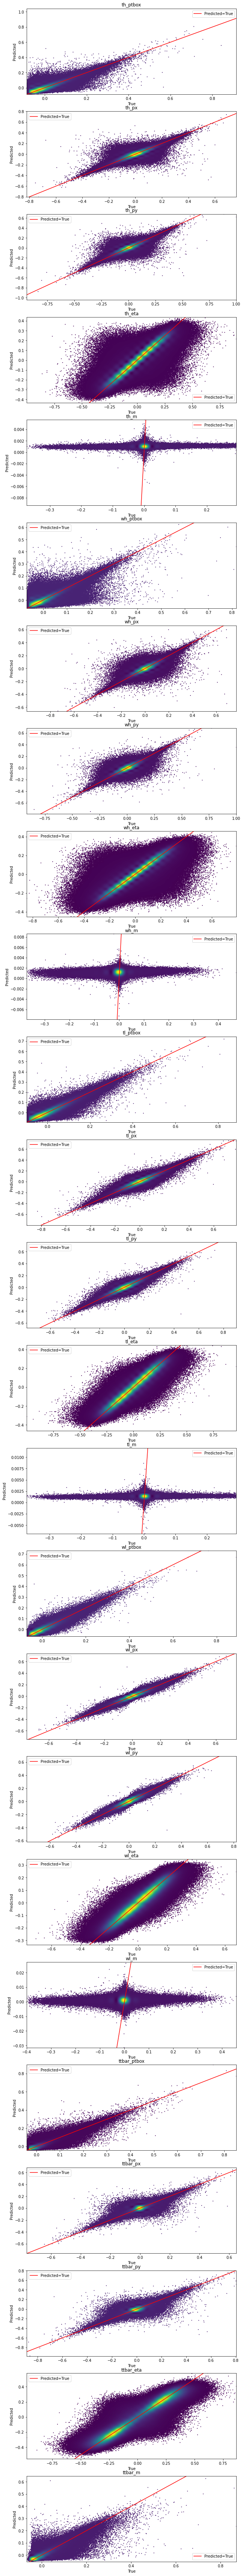

In [12]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

## Original Scale Plots

In [13]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 689.1665601121703
 
th_pt MSE, MAE :  1848.3655973503 29.0425414320
th_eta MSE, MAE :  0.4663029101 0.3803739766
th_phi MSE, MAE :  0.6892920013 0.4535033265
th_m MSE, MAE :  35.3483631441 2.1279588945
wh_pt MSE, MAE :  1365.7848270444 23.2553001002
wh_eta MSE, MAE :  0.5400519677 0.4128134672
wh_phi MSE, MAE :  0.6574962624 0.4546449146
wh_m MSE, MAE :  36.2789604439 2.6251229061
tl_pt MSE, MAE :  1265.2078839295 25.4330068594
tl_eta MSE, MAE :  0.2982219409 0.3592041410
tl_phi MSE, MAE :  0.4098986537 0.3352340749
tl_m MSE, MAE :  35.9905165599 2.1417545928
wl_pt MSE, MAE :  626.4061861873 18.4436835265
wl_eta MSE, MAE :  0.2916628250 0.3844958633
wl_phi MSE, MAE :  0.1875132987 0.2446972473
wl_m MSE, MAE :  37.2245074034 2.6625896839
ttbar_pt MSE, MAE :  1532.3295195380 25.9012843374
ttbar_eta MSE, MAE :  0.8529906254 0.6351342513
ttbar_phi MSE, MAE :  1.2465308413 0.7647331305
ttbar_m MSE, MAE :  6987.0517395331 52.7871478958


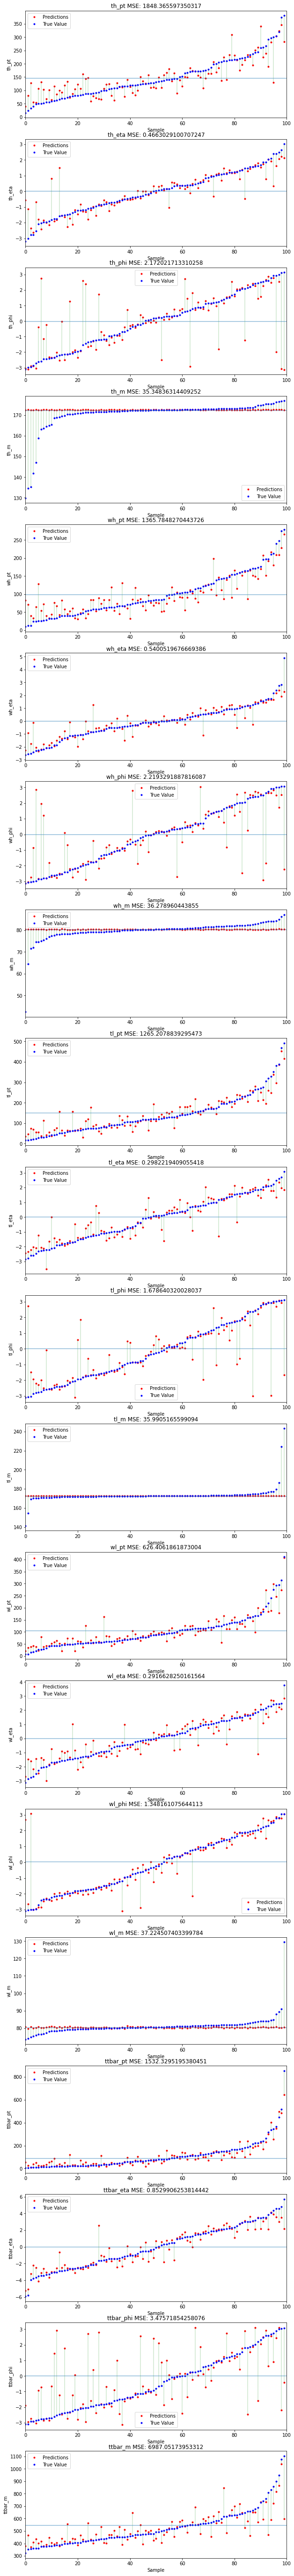

In [14]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

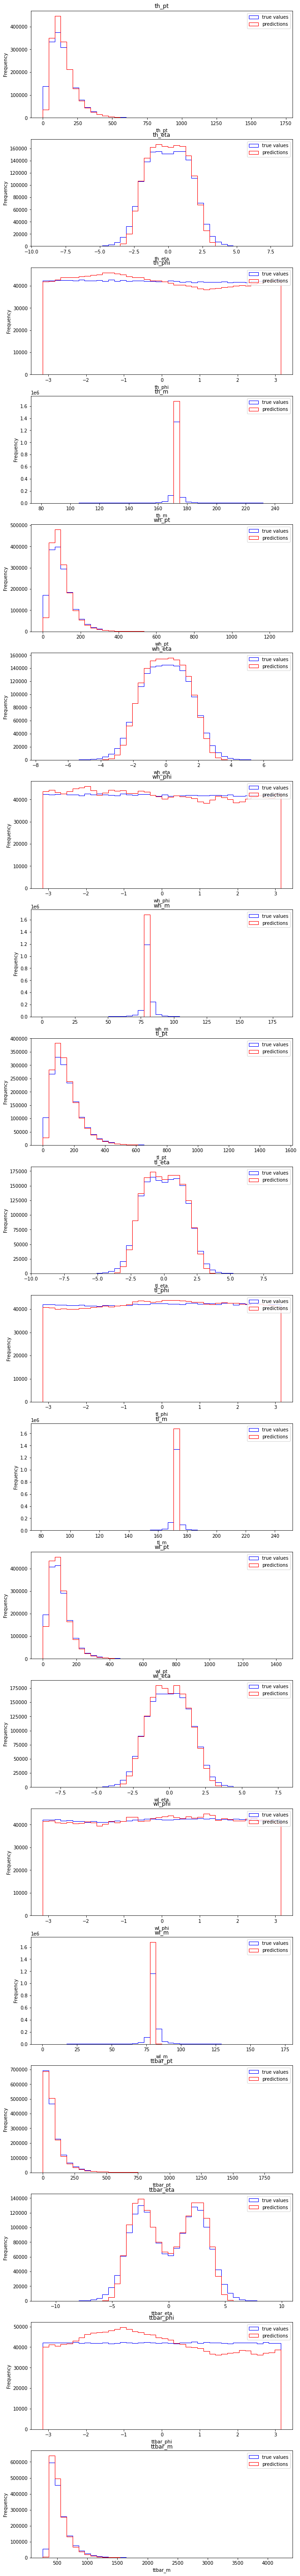

In [15]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

/home/jchishol/myVenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


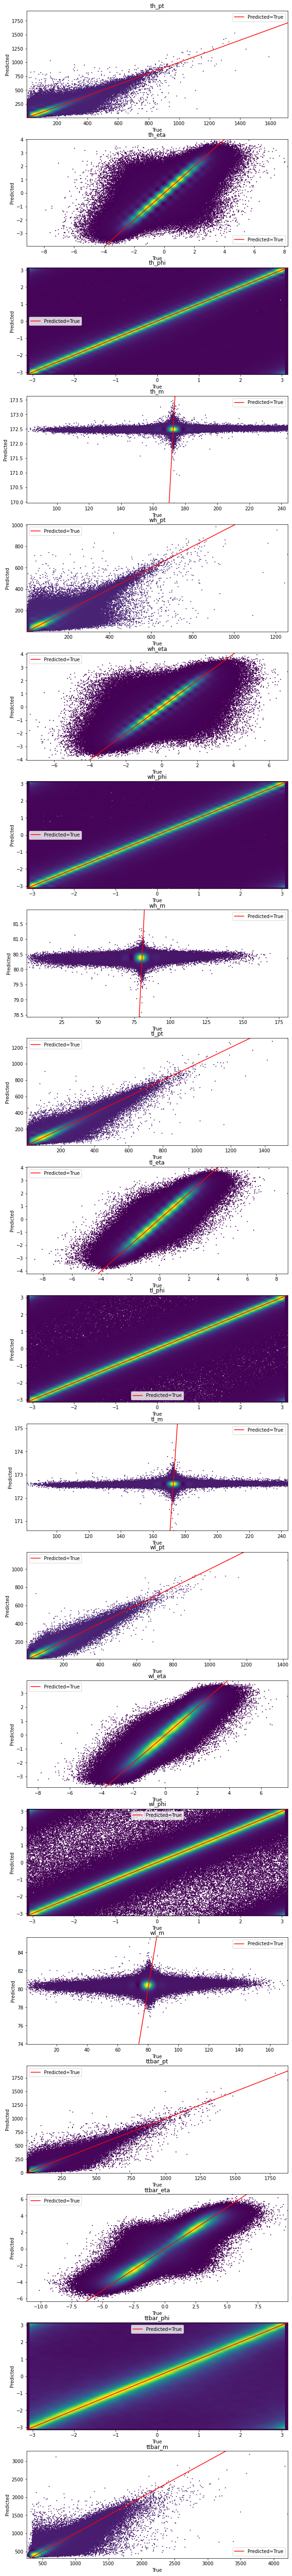

In [16]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

## Observables

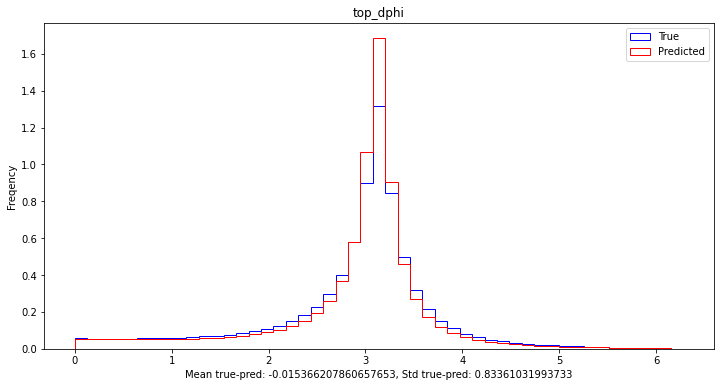

In [17]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

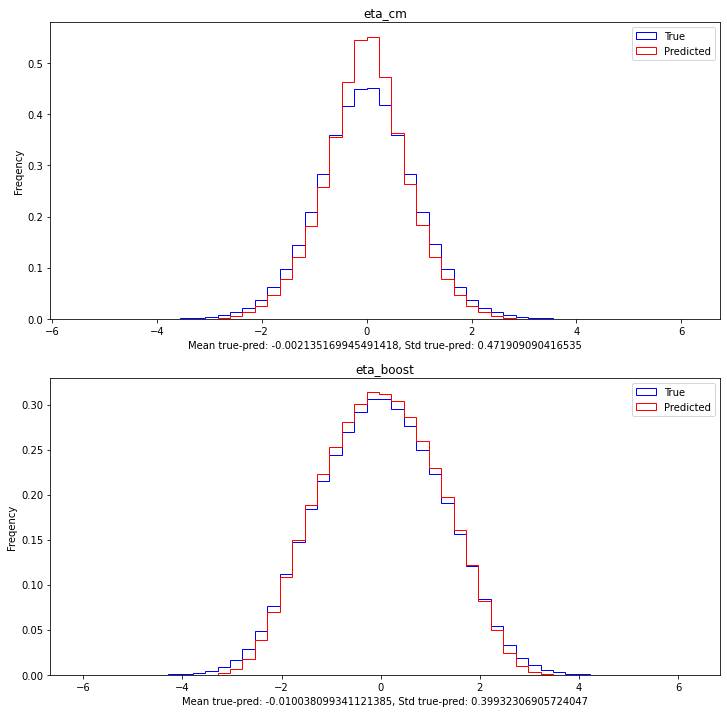

In [18]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])

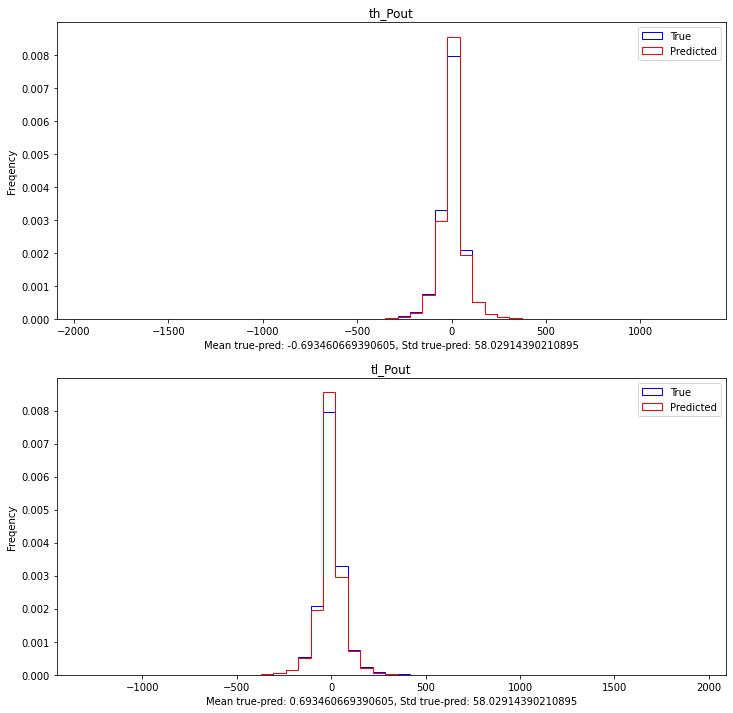

In [19]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

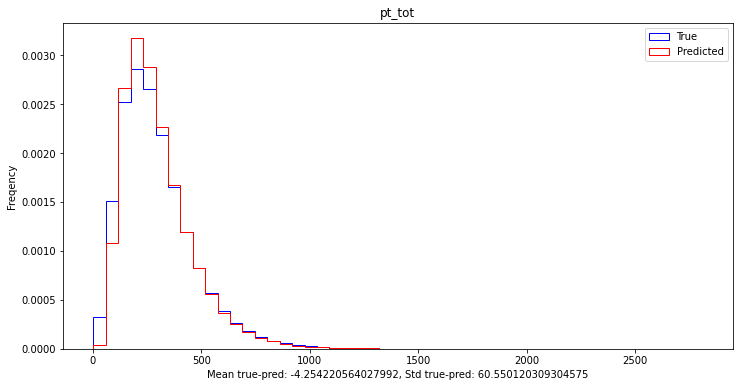

In [20]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])